# **Python script to download latest DOME Registry contents, related full text papers & provide DOME Registry entries metadata read out (20241202)**
1. DOME Registry contents will be downloaded by API call proividng the json file of DOME Registry data
2. DOME Registry data json will be flattened and converted into CSV for working with entries data (row based data)
3. DOME Registry CSV will be checked and used to produce a metadata readout file (+ graphs)
4. DOME Registry DOIs of articles will be convrted to PMCIDs for full text retrieval 
5. DOME Registry entries will be downloaded as full XML files using EPMC when API works
6. DOME Registry title and abstracts downlaoded from EPMC to support data analaysis where no full text is available
7. Metadata and graphs produced on available DOME Registry articles retrieval

#### To do: dockerise & put into simple run script vs jupyter notebook


## 1. Latest DOME Registry contents will be downloaded by DOME Registry API call proividing the .json file of DOME Registry data for the given day 

In [3]:
# 1. Use the DOME API to download all entries of the DOME Registry and store them in a json file 
import os
from datetime import datetime
import requests

# Define the URL for the call
url = "https://registry.dome-ml.org/api/review?skip=0&limit=250&text=%20&public=true&sort=publication.year&asc=true"

# Make an API request to the URL to check the response
response = requests.get(url, headers={'accept': '*/*'})

# Create folder to store all JSON files
if not os.path.exists('DOME_Registry_JSON_Files'):
    os.makedirs('DOME_Registry_JSON_Files')
else:
    print('Folder already exists for storing DOME Registry JSON files, files will be stored here')

# Specify the desired folder path for JSON files
json_folder_path = "DOME_Registry_JSON_Files"

# Check if the request was successful
if response.status_code == 200:
    # Get the current date in ISO format for file naming
    current_date = datetime.now().strftime('%Y-%m-%d')

    # Create the output file name 
    file_name = f"DOME_Registry_Contents_{current_date}.json"
    json_file_path = os.path.join(json_folder_path, file_name)

    # Check if the file pathway already exists
    if os.path.exists(json_file_path):
        print(f"File already exists for today's date.")
        overwrite = input('Do you want to overwrite the file? (y/n): ') 
        if overwrite.lower() != 'y':
            print('Exiting without overwriting file')
        else:
            print('Overwriting file')
            # Save the content to a file
            with open(json_file_path, 'w', encoding='utf-8') as file:
                file.write(response.text)
            print(f"DOME Registry data downloaded and saved to '{json_file_path}'")
    else:
        print('Saving file')
        # Save the content to a file
        with open(json_file_path, 'w', encoding='utf-8') as file:
            file.write(response.text)
        print(f"DOME Registry data downloaded and saved to '{json_file_path}'")
else:
    print(f"Failed to retrieve the data. Status code: {response.status_code}")


Folder already exists for storing DOME Registry JSON files, files will be stored here
Saving file
DOME Registry data downloaded and saved to 'DOME_Registry_JSON_Files/DOME_Registry_Contents_2025-02-06.json'


## 2. DOME Registry data .json file will be flattened and converted into CSV for easier working with entries data (row and column based data format)

In [4]:
# 2. Produce DOME Registry contents metadata .csv file and data visualisation
import json

# 2.1 Pretty print DOME Registry contents JSON file for inspection to ensure all looks as expected 
# remove comment to acitvate print and debug where needed

# Function to read in and pretty-print the JSON DOME Registry file entry
def pretty_print_json(file_name):
    try:
        # Open and read the JSON file
        with open(file_name, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        # Pretty-print the JSON data
        print('Successfully read in JSON file.')
        #print(json.dumps(data, indent=4))
    
    except Exception as e:
        print(f"Error reading the JSON file: {e}")

# Call the function to pretty-print the JSON file
pretty_print_json(json_file_path)


# 2.2 Flatten the JSON for easier data processing and write to a new .json file 
# Function to read JSON data
def read_json(file_name):
    try:
        with open(file_name, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data
    except Exception as e:
        print(f"Error reading the JSON file: {e}")
        return None

# Function to flatten JSON
def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

# Function to save flattened JSON to a file
def save_flattened_json(flattened_data, output_file_name):
    try:
        with open(output_file_name, 'w', encoding='utf-8') as file:
            json.dump(flattened_data, file, indent=4)
        print(f"Flattened JSON data saved to '{output_file_name}'")
    except Exception as e:
        print(f"Error saving the flattened JSON file: {e}")

# Read JSON data
data = read_json(json_file_path)

# Flatten JSON data and save to a new JSON file
if data:
    flattened_data = [flatten_json(entry) for entry in data]
    flattened_file_name = ("flattened_"+file_name)
    # Make file path to save flattened JSON file
    json_folder_path = "DOME_Registry_JSON_Files"
    json_file_path = os.path.join(json_folder_path, flattened_file_name)
    save_flattened_json(flattened_data, json_file_path)
    # Print the flattened JSON data to view it

else:
    print("No data to process.")

#2.3 Convert flattened json to csv 
# Function to read flattened JSON data
import json
import csv
import os

# Define the path to the flattened JSON file
#flattened_file_name = 'flattened_DOME_Registry_Contents.json'  # Replace with your actual file name

# Function to read flattened JSON data
def read_flattened_json(file_name):
    try:
        with open(file_name, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data
    except Exception as e:
        print(f"Error reading the flattened JSON file: {e}")
        return None

# CSV folders created to store csv
if not os.path.exists('DOME_Registry_CSV_Files'):
    print('Creating folder to store DOME Registry CSV files')
    os.makedirs('DOME_Registry_CSV_Files')
else:
    print('Folder already exists for storing DOME Registry CSV files')

# Function to write JSON data to a CSV file
def write_json_to_csv(json_data, csv_file_name):
    try:
        # Determine all possible headers from the entire dataset
        headers = set()
        for entry in json_data:
            headers.update(entry.keys())
        headers = list(headers)
        
        # Write data to CSV file
        with open(csv_file_name, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=headers)
            writer.writeheader()
            for entry in json_data:
                writer.writerow(entry)
        
        print(f"JSON data written to '{csv_file_name}'")
    except Exception as e:
        print(f"Error writing to the CSV file: {e}")

# Read flattened JSON data
flattened_data = read_flattened_json(json_file_path)

# Create CSV file name and file pathway
csv_file_name = flattened_file_name[:-5]+'.csv'
csv_file_path = os.path.join('DOME_Registry_CSV_Files', csv_file_name)

# Process JSON data into CSV
if flattened_data:
    write_json_to_csv(flattened_data, csv_file_path)
else:
    print("No data to process.")

csv_file_name = flattened_file_name[:-5]+'.csv'

Successfully read in JSON file.
Flattened JSON data saved to 'DOME_Registry_JSON_Files/flattened_DOME_Registry_Contents_2025-02-06.json'
Folder already exists for storing DOME Registry CSV files
JSON data written to 'DOME_Registry_CSV_Files/flattened_DOME_Registry_Contents_2025-02-06.csv'


## 3. DOME Registry CSV data file will be formatted with shortid as the row index and other fields cleaned (publication data) and ordered by D O M E fields 

In [5]:
#3 Reorder CSV using pandas data frame 
import pandas as pd

# Read the CSV file as a DataFrame using pandas
df = pd.read_csv(csv_file_path)

# Define the prefixes to match and group csv data
prefix_publications_cols = 'publication_'
prefix_data_cols = 'matches_data'
prefix_optimization_cols = 'matches_optimization'
prefix_model_cols = 'matches_model'
prefix_evaluation_cols = 'matches_evaluation'

# Separate columns based on whether they start with the prefix
publication_columns = [col for col in df.columns if col.startswith(prefix_publications_cols)]
matches_data_columns = [col for col in df.columns if col.startswith(prefix_data_cols)]
matches_optimization_columns = [col for col in df.columns if col.startswith(prefix_optimization_cols)]
matches_model_columns = [col for col in df.columns if col.startswith(prefix_model_cols)]
matches_evaluation_columns = [col for col in df.columns if col.startswith(prefix_evaluation_cols)]
other_columns = [col for col in df.columns if not col.startswith('matches_') and not col.startswith('publication_')]

# Reorder columns
reordered_columns = (other_columns + publication_columns + matches_data_columns +
                     matches_optimization_columns + matches_model_columns + matches_evaluation_columns)
df = df[reordered_columns]

# Print the reordered DataFrame
#print(df.head())

df = pd.DataFrame(df).set_index('shortid')
#csv_file_name = os.path.join('DOME_Registry_CSV_Files',csv_file_name)
df.to_csv(csv_file_path, sep=',', index=True, encoding='utf-8') 

print(f"Reordered CSV data saved to '{csv_file_path}'")

Reordered CSV data saved to 'DOME_Registry_CSV_Files/flattened_DOME_Registry_Contents_2025-02-06.csv'


## 4. DOME Registry data csv will have a column added at the end with PMCIDs returned from DOI search using NCBI E-Utilities API 

In [36]:
# 4. From DOIs get PMCIDs full text search
# DOIs to PMCIDs
import pandas as pd
import requests

# Read in DOME Entries CSV as dataframe via pandas library functions
df = pd.read_csv(csv_file_path)

# Extract DOIs from the DataFrame
dois = df['publication_doi'].dropna().unique()

# Clean the DOIs to remove https://doi.org/ prefix
dois = [doi.replace('https://doi.org/', '') for doi in dois]

# Function to map DOIs to PMCIDs using NCBI E-utilities API
def map_dois_to_pmcids(dois, batch_size=1):
    pmcid_mapping = {}
    for i in range(0, len(dois), batch_size):
        batch = dois[i:i + batch_size]
        doi_str = ','.join(batch)
        url = f"https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/?tool=my_tool&email=my_email@example.com&ids={doi_str}&format=json"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            records = data.get('records', [])
            if records:
                for record in records:
                    doi = record.get('doi')
                    pmcid = record.get('pmcid')
                    pmcid_mapping[doi] = pmcid
        else:
            for doi in batch:
                pmcid_mapping[doi] = None
    return pmcid_mapping

# Map DOIs to PMCIDs
doi_to_pmcid_mapping = map_dois_to_pmcids(dois)

# Add the mapped PMCIDs to the DataFrame
df['mapped_pmcid'] = df['publication_doi'].map(doi_to_pmcid_mapping)

# Save the updated DataFrame to a new CSV file in the SV folder
output_csv_file_name = f'DOME_Registry_CSV_Files/PMCIDs_DOME_Registry_Contents_{current_date}.csv'
df.to_csv(output_csv_file_name, index=False)
print(f"Updated DataFrame with mapped PMCIDs saved to '{output_csv_file_name}'")
# Print the updated DataFrame
#print(df['mapped_pmcid'])

# to speed up add check if alreadfy downlaoded and then only do ones not downloaded

Updated DataFrame with mapped PMCIDs saved to 'DOME_Registry_CSV_Files/PMCIDs_DOME_Registry_Contents_2025-02-06.csv'


## 5. Use EPMC API to return and save full text xml of all DOME Registry entries and store in folder named DOME_Registry_PMC_full_texts

In [34]:
# 5. Download using epmc api the full text using pmcids into folder
 
import pandas as pd
import requests
import os

# Define the path to your CSV file
# csv_file_name = 'updated_DOME_Registry_Contents.csv'  # Replace with your actual file name

# Read in DOME Entries CSV as dataframe via pandas library functions
df = pd.read_csv(output_csv_file_name)

# Extract PMCIDs from the DataFrame
pmcids = df['mapped_pmcid'].dropna().unique()

# Define the output folder for full text files
output_folder = 'DOME_Registry_PMC_Full_Texts'
os.makedirs(output_folder, exist_ok=True)

# Function to download full text for each PMCID using Europe PMC API
def download_full_text(pmcids):
    for pmcid in pmcids:
        url = f"https://www.ebi.ac.uk/europepmc/webservices/rest/{pmcid}/fullTextXML"
        response = requests.get(url)
        if response.status_code == 200:
            full_text = response.text
            output_file = os.path.join(output_folder, f"{pmcid}.xml")
            with open(output_file, 'w', encoding='utf-8') as file:
                file.write(full_text)
            print(f"Full text for PMCID {pmcid} saved to '{output_file}'")
        else:
            print(f"Failed to retrieve full text for PMCID {pmcid}. Status code: {response.status_code}")

# Download full text for each PMCID - takes approx 3-5 seconds each, so a few minutes totoal dependingn on DOME Registry erntries size
download_full_text(pmcids)

# print how many successfully downloaded and how many failed to download - TO ADD
# to speed up add check if alreadfy downlaoded and then only do ones not downloaded


Full text for PMCID PMC1421439 saved to 'DOME_Registry_PMC_Full_Texts/PMC1421439.xml'
Full text for PMCID PMC1847686 saved to 'DOME_Registry_PMC_Full_Texts/PMC1847686.xml'
Full text for PMCID PMC2213690 saved to 'DOME_Registry_PMC_Full_Texts/PMC2213690.xml'
Full text for PMCID PMC1892091 saved to 'DOME_Registry_PMC_Full_Texts/PMC1892091.xml'
Full text for PMCID PMC2638158 saved to 'DOME_Registry_PMC_Full_Texts/PMC2638158.xml'
Full text for PMCID PMC2665034 saved to 'DOME_Registry_PMC_Full_Texts/PMC2665034.xml'
Full text for PMCID PMC2275242 saved to 'DOME_Registry_PMC_Full_Texts/PMC2275242.xml'
Full text for PMCID PMC2561051 saved to 'DOME_Registry_PMC_Full_Texts/PMC2561051.xml'
Full text for PMCID PMC2660303 saved to 'DOME_Registry_PMC_Full_Texts/PMC2660303.xml'
Full text for PMCID PMC2752621 saved to 'DOME_Registry_PMC_Full_Texts/PMC2752621.xml'
Full text for PMCID PMC3009519 saved to 'DOME_Registry_PMC_Full_Texts/PMC3009519.xml'
Failed to retrieve full text for PMCID PMC3169429. Sta

In [60]:
# 5. Download using epmc api the full text using pmcids into folder
 
import pandas as pd
import requests
import os

# Define the path to your CSV file
# csv_file_name = 'updated_DOME_Registry_Contents.csv'  # Replace with your actual file name

# Read in DOME Entries CSV as dataframe via pandas library functions
df = pd.read_csv(output_csv_file_name)

# Extract PMCIDs from the DataFrame
pmcids = df['mapped_pmcid'].dropna().unique()
# Empty list to add not yet downloaded PMCIDs to try download full texts
to_download_pmcid = []

# Check if PMCID already used and downloaded correpsonding full text
for pmcid in pmcids:
    if os.path.exists(f'DOME_Registry_PMC_Full_Texts/{pmcid}.xml'):
        print(f"Full text for PMCID {pmcid} already downloaded.")
    else:
        print(f"Full text for PMCID {pmcid} not yet downloaded.")
        to_download_pmcid.append(pmcid)

# Define the output folder for full text files
output_folder = 'DOME_Registry_PMC_Full_Texts'
os.makedirs(output_folder, exist_ok=True)

# Function to download full text for each PMCID using Europe PMC API
def download_full_text(pmcids):
    for pmcid in pmcids:
        url = f"https://www.ebi.ac.uk/europepmc/webservices/rest/{pmcid}/fullTextXML"
        response = requests.get(url)
        if response.status_code == 200:
            full_text = response.text
            output_file = os.path.join(output_folder, f"{pmcid}.xml")
            with open(output_file, 'w', encoding='utf-8') as file:
                file.write(full_text)
            print(f"Full text for PMCID {pmcid} saved to '{output_file}'")
        else:
            print(f"Failed to retrieve full text for PMCID {pmcid}. Status code: {response.status_code}")

# Download full text for each PMCID - takes approx 3-5 seconds each, so a few minutes totoal dependingn on DOME Registry erntries size
download_full_text(to_download_pmcid )

# Print how many successfully downloaded and how many failed to download and append to csv
# Empty list to cpature download status and use to append as new column in csv
full_text_downloadable = []

pmcids = df['mapped_pmcid']

for pmcid in pmcids:
    if os.path.exists(f'DOME_Registry_PMC_Full_Texts/{pmcid}.xml'):
        full_text_downloadable.append('yes')
    else:
        full_text_downloadable.append('no')
         
# Add the new column of dowenload status to the DataFrame and save new csv
df['full_text_downloadable'] = full_text_downloadable
df.to_csv(output_csv_file_name, index=False)
print(f"Updated CSV with full text download status saved to '{output_csv_file_name}'")


Full text for PMCID PMC1421439 already downloaded.
Full text for PMCID PMC1847686 already downloaded.
Full text for PMCID PMC2213690 already downloaded.
Full text for PMCID PMC1892091 already downloaded.
Full text for PMCID PMC2638158 already downloaded.
Full text for PMCID PMC2665034 already downloaded.
Full text for PMCID PMC2275242 already downloaded.
Full text for PMCID PMC2561051 already downloaded.
Full text for PMCID PMC2660303 already downloaded.
Full text for PMCID PMC2752621 already downloaded.
Full text for PMCID PMC3009519 already downloaded.
Full text for PMCID PMC3169429 not yet downloaded.
Full text for PMCID PMC3542245 already downloaded.
Full text for PMCID PMC3396452 already downloaded.
Full text for PMCID PMC3292016 already downloaded.
Full text for PMCID PMC3340366 already downloaded.
Full text for PMCID PMC4289375 already downloaded.
Full text for PMCID PMC3967921 already downloaded.
Full text for PMCID PMC4058174 already downloaded.
Full text for PMCID PMC3912131 

# 6. Download the title and abstract to support data analaysis where no full text is available



In [62]:
# 6. Download the title and abstract + other data as additional data to support data analaysis where no full text is available
import os
import requests

# Function to fetch article details from Europe PMC
def fetch_article_details(pmcid):
    url = f"https://www.ebi.ac.uk/europepmc/webservices/rest/search?query=PMCID:{pmcid}&resultType=core&format=json"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data['hitCount'] > 0:
            article = data['resultList']['result'][0]
            title = article.get('title', 'No title available')
            abstract = article.get('abstractText', 'No abstract available')
            return title, abstract
    return None, None

# Function to save article details to a file
def save_article_details(pmcid, title, abstract, folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
    file_path = os.path.join(folder, f"{pmcid}.txt")
    with open(file_path, 'w') as file:
        file.write(f"Title: {title}\n\n")
        file.write(f"Abstract: {abstract}\n")

# List of PMCID to download
df = pd.read_csv(output_csv_file_name)
pmcids = df['mapped_pmcid'] 
# Empty to download PMCIDs list where title and abstract not yet downloaded
to_download_pmcid = []

# Folder to save the articles
folder = 'DOME_Registry_PMC_Title_Abstract'

# Check if title and abstract already downloaded
for pmcid in pmcids:
    if os.path.exists(f'{folder}/{pmcid}.txt'):
        print(f"Title and abstract for PMCID {pmcid} already downloaded.")
    else:
        print(f"Title and abstract for PMCID {pmcid} not yet downloaded.")
        to_download_pmcid.append(pmcid)

# Fetch and save articles
for pmcid in to_download_pmcid:
    title, abstract = fetch_article_details(pmcid)
    if title and abstract:
        save_article_details(pmcid, title, abstract, folder)
        print(f"Downloaded and saved article {pmcid}")
    else:
        print(f"Failed to download article {pmcid}")


# Print how many successfully downloaded and how many failed to download and append to csv
# Empty list to cpature download status and use to append as new column in csv
abstract_title_downloadable = []

pmcids = df['mapped_pmcid']

for pmcid in pmcids:
    if os.path.exists(f'DOME_Registry_PMC_Title_Abstract/{pmcid}.txt'):
        abstract_title_downloadable.append('yes')
    else:
        abstract_title_downloadable.append('no')
         
# Add the new column of dowenload status to the DataFrame and save new csv
df['abstract_title_downloadable'] = abstract_title_downloadable
df.to_csv(output_csv_file_name, index=False)
print(f"Updated CSV with full text download status saved to '{output_csv_file_name}'")

Title and abstract for PMCID PMC1421439 already downloaded.
Title and abstract for PMCID PMC1847686 already downloaded.
Title and abstract for PMCID PMC2213690 already downloaded.
Title and abstract for PMCID PMC1892091 already downloaded.
Title and abstract for PMCID PMC2638158 already downloaded.
Title and abstract for PMCID PMC2665034 already downloaded.
Title and abstract for PMCID PMC2275242 already downloaded.
Title and abstract for PMCID PMC2561051 already downloaded.
Title and abstract for PMCID PMC2660303 already downloaded.
Title and abstract for PMCID PMC2752621 already downloaded.
Title and abstract for PMCID nan not yet downloaded.
Title and abstract for PMCID PMC3009519 already downloaded.
Title and abstract for PMCID PMC3169429 already downloaded.
Title and abstract for PMCID PMC3542245 already downloaded.
Title and abstract for PMCID PMC3396452 already downloaded.
Title and abstract for PMCID PMC3292016 already downloaded.
Title and abstract for PMCID PMC3340366 already

## 7. Metadata generated on DOME Entries data csv such as of availability of full text XML files, total entries, etc + some graphs of data validity vs expected inputs 

221
Metadata saved to 'DOME_Registry_CSV_Files/DOME_Metadata.csv'
Bar charts saved to 'DOME_Registry_CSV_Files/DOME_Metadata_Bar_Charts.png'


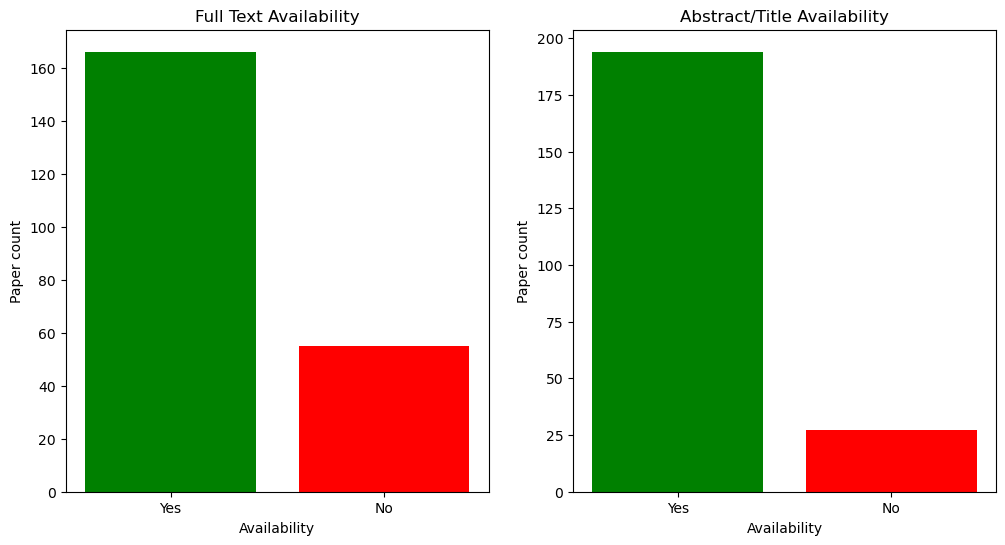

In [67]:

# 7. Create metadata file readout as a csv, corresponding text file to explain contents and graphs to go with these
# Metadata file readout as CSV and text file to explain contents and graph visualisation of data validation 

#import libraries
import csv
import re
import os
import pandas as pd
import matplotlib.pyplot as plt

# 7.1 Calculate metadata and produce csv file + simple bar plots
# Read in csv with pandas into dataframe for analysis
ddf = pd.read_csv(output_csv_file_name)
df = df.set_index('shortid')
#df.head()

# Get dataframe total entries count based on rows in index

# Set empty counter for rows count, this will be used as the figure of DOME Resgitry entries in the csv data downloaded
rows = 0
for row in df.index:
    #print(row)
    rows = rows + 1
print(rows)

# For entry rows count how many empty or non-conforming rows (regex checks)
df.head()

# Read in the CSV file
df = pd.read_csv(output_csv_file_name)

# Calculate metadata
total_entries = len(df)
full_text_yes = df['full_text_downloadable'].value_counts().get('yes', 0)
full_text_no = df['full_text_downloadable'].value_counts().get('no', 0)
abstract_title_yes = df['abstract_title_downloadable'].value_counts().get('yes', 0)
abstract_title_no = df['abstract_title_downloadable'].value_counts().get('no', 0)

# Create a metadata DataFrame
metadata = pd.DataFrame({
    'Metric': ['Total Entries', 'Full Text Available (Yes)', 'Full Text Available (No)', 'Abstract/Title Available (Yes)', 'Abstract/Title Available (No)'],
    'Count': [total_entries, full_text_yes, full_text_no, abstract_title_yes, abstract_title_no]
})

# Save metadata to a new CSV file
metadata_csv_path = 'DOME_Registry_CSV_Files/DOME_Metadata.csv'
metadata.to_csv(metadata_csv_path, index=False)
print(f"Metadata saved to '{metadata_csv_path}'")

# Plot bar charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for full text availability
axes[0].bar(['Yes', 'No'], [full_text_yes, full_text_no], color=['green', 'red'])
axes[0].set_title('Full Text Availability')
axes[0].set_xlabel('Availability')
axes[0].set_ylabel('Paper count')

# Bar chart for abstract/title availability
axes[1].bar(['Yes', 'No'], [abstract_title_yes, abstract_title_no], color=['green', 'red'])
axes[1].set_title('Abstract/Title Availability')
axes[1].set_xlabel('Availability')
axes[1].set_ylabel('Paper count')

# Save the plot as an image file
plot_image_path = 'DOME_Registry_CSV_Files/DOME_Metadata_Bar_Charts.png'
plt.savefig(plot_image_path)
print(f"Bar charts saved to '{plot_image_path}'")

# Show the plot
plt.show()

# To add
# 6.2 Turn csv data into corresponding text file to verbally explain metrics
# 6.3 Turn csv into into corresponding graphed data to visualise the metrics

